<a href="https://colab.research.google.com/github/Yujin726/0624/blob/main/07_07_Open_CV_colab_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 파일 업로드 예시 코드

In [3]:
# 📂 파일 업로드
from google.colab import files
import io
from PIL import Image
import numpy as np
import cv2

# 파일 업로드
uploaded = files.upload()

# 이미지 파일 읽기 및 BGR(OpenCV 형식)로 변환
img = cv2.cvtColor(
    np.array(Image.open(io.BytesIO(uploaded[list(uploaded.keys())[0]]))),
    cv2.COLOR_RGB2BGR
)

# 결과 이미지 크기 확인 (선택)
print("이미지 크기:", img.shape)

Saving 스크린샷 2025-07-07 112538.png to 스크린샷 2025-07-07 112538 (1).png
이미지 크기: (815, 474, 3)


#교통 표지판 분류기 훈련 기본 코드

In [ ]:
!pip install opencv-python tensorflow scikit-learn matplotlib pillow
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import os
from PIL import Image

class AutonomousDrivingMLSystem:
    def __init__(self):
        self.lane_detector = None
        self.traffic_sign_classifier = None
        self.speed_predictor = None

    def preprocess_image(self, image_path):
        """이미지 전처리 함수"""
        image = cv2.imread(image_path)
        if image is None:
            return None

        # 크기 조정
        image = cv2.resize(image, (224, 224))
        # 정규화
        image = image.astype(np.float32) / 255.0
        return image

    def detect_lane_features(self, image):
        """차선 특징 추출"""
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # 가우시안 블러 적용
        blur = cv2.GaussianBlur(gray, (5, 5), 0)

        # 에지 검출
        edges = cv2.Canny(blur, 50, 150)

        # 관심 영역 설정 (도로 하단부)
        height = edges.shape[0]
        mask = np.zeros_like(edges)
        polygon = np.array([[
            (0, height),
            (edges.shape[1], height),
            (edges.shape[1], height//2),
            (0, height//2)
        ]], np.int32)
        cv2.fillPoly(mask, polygon, 255)
        masked_edges = cv2.bitwise_and(edges, mask)

        # 허프 변환으로 직선 검출
        lines = cv2.HoughLinesP(masked_edges, 1, np.pi/180,
                               threshold=50, minLineLength=100, maxLineGap=50)

        features = []
        if lines is not None:
            for line in lines:
                x1, y1, x2, y2 = line[0]
                # 기울기와 길이 계산
                if x2 - x1 != 0:
                    slope = (y2 - y1) / (x2 - x1)
                    length = np.sqrt((x2-x1)**2 + (y2-y1)**2)
                    features.extend([slope, length, x1, y1, x2, y2])

        # 고정 길이로 맞추기
        while len(features) < 30:
            features.append(0)
        return features[:30]

    def build_traffic_sign_cnn(self):
        """교통 표지판 분류를 위한 CNN 모델"""
        model = models.Sequential([
            layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.Flatten(),
            layers.Dense(64, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(4, activation='softmax')  # 4개 클래스: 정지, 직진, 좌회전, 우회전
        ])

        model.compile(optimizer='adam',
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])
        return model

    def generate_sample_data(self):
        """샘플 데이터 생성 (실제로는 실제 도로 이미지를 사용)"""
        # 차선 특징 데이터 생성
        np.random.seed(42)
        lane_features = []
        lane_decisions = []

        for i in range(1000):
            # 30개 특징 (기울기, 길이, 좌표 등)
            features = np.random.randn(30)

            # 차선 중앙 유지 여부 결정 (0: 좌회전, 1: 직진, 2: 우회전)
            if features[0] < -0.5:  # 왼쪽 기울기가 강함
                decision = 0  # 우회전으로 보정
            elif features[0] > 0.5:  # 오른쪽 기울기가 강함
                decision = 2  # 좌회전으로 보정
            else:
                decision = 1  # 직진

            lane_features.append(features)
            lane_decisions.append(decision)

        # 교통 표지판 이미지 데이터 생성 (실제로는 실제 표지판 이미지)
        sign_images = np.random.rand(500, 64, 64, 3)
        sign_labels = np.random.randint(0, 4, 500)

        return np.array(lane_features), np.array(lane_decisions), sign_images, sign_labels

    def train_lane_keeping_system(self):
        """차선 유지 시스템 훈련"""
        print("차선 유지 시스템 훈련 시작...")

        # 샘플 데이터 생성
        lane_features, lane_decisions, _, _ = self.generate_sample_data()

        # 훈련/테스트 데이터 분할
        X_train, X_test, y_train, y_test = train_test_split(
            lane_features, lane_decisions, test_size=0.2, random_state=42
        )

        # 랜덤 포레스트 분류기 훈련
        self.lane_detector = RandomForestClassifier(n_estimators=100, random_state=42)
        self.lane_detector.fit(X_train, y_train)

        # 성능 평가
        y_pred = self.lane_detector.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)

        print(f"차선 유지 시스템 정확도: {accuracy:.3f}")
        print("\n분류 보고서:")
        print(classification_report(y_test, y_pred,
                                   target_names=['좌회전', '직진', '우회전']))

        return accuracy

    def train_traffic_sign_classifier(self):
        """교통 표지판 분류기 훈련"""
        print("\n교통 표지판 분류기 훈련 시작...")

        # 샘플 데이터 생성
        _, _, sign_images, sign_labels = self.generate_sample_data()

        # 훈련/테스트 데이터 분할
        X_train, X_test, y_train, y_test = train_test_split(
            sign_images, sign_labels, test_size=0.2, random_state=42
        )

        # CNN 모델 생성 및 훈련
        self.traffic_sign_classifier = self.build_traffic_sign_cnn()

        history = self.traffic_sign_classifier.fit(
            X_train, y_train,
            epochs=10,
            batch_size=32,
            validation_data=(X_test, y_test),
            verbose=1
        )

        # 성능 평가
        test_loss, test_accuracy = self.traffic_sign_classifier.evaluate(X_test, y_test, verbose=0)
        print(f"\n교통 표지판 분류 정확도: {test_accuracy:.3f}")

        return test_accuracy

    def predict_driving_action(self, image_path):
        """주행 행동 예측"""
        if not os.path.exists(image_path):
            print("이미지 파일을 찾을 수 없습니다.")
            return None

        # 이미지 전처리
        image = self.preprocess_image(image_path)
        if image is None:
            return None

        # 차선 특징 추출
        lane_features = self.detect_lane_features((image * 255).astype(np.uint8))

        # 차선 기반 주행 방향 예측
        if self.lane_detector:
            lane_decision = self.lane_detector.predict([lane_features])[0]
            lane_actions = ['좌회전', '직진', '우회전']

            print(f"차선 분석 결과: {lane_actions[lane_decision]}")

        # 교통 표지판 분류 (64x64 크기로 조정)
        if self.traffic_sign_classifier:
            sign_image = cv2.resize((image * 255).astype(np.uint8), (64, 64))
            sign_image = np.expand_dims(sign_image.astype(np.float32) / 255.0, axis=0)

            sign_prediction = self.traffic_sign_classifier.predict(sign_image, verbose=0)
            sign_class = np.argmax(sign_prediction[0])
            sign_confidence = np.max(sign_prediction[0])

            sign_names = ['정지', '직진', '좌회전', '우회전']
            print(f"교통표지판 인식: {sign_names[sign_class]} (신뢰도: {sign_confidence:.3f})")

        return lane_decision if self.lane_detector else None

def main():
    """메인 실행 함수"""
    print("=== 자율주행 지도학습 시스템 ===\n")

    # 시스템 초기화
    autonomous_system = AutonomousDrivingMLSystem()

    # 모델 훈련
    lane_accuracy = autonomous_system.train_lane_keeping_system()
    sign_accuracy = autonomous_system.train_traffic_sign_classifier()

    print(f"\n=== 훈련 완료 ===")
    print(f"차선 유지 시스템 정확도: {lane_accuracy:.1%}")
    print(f"교통표지판 분류 정확도: {sign_accuracy:.1%}")

    # 샘플 이미지로 테스트 (실제 파일이 있다면)
    # test_image = "sample_road.jpg"
    # result = autonomous_system.predict_driving_action(test_image)

if __name__ == "__main__":
    main()


#교통 표지판 분류기 훈련_ 표지판 샘플 이미지 포함!

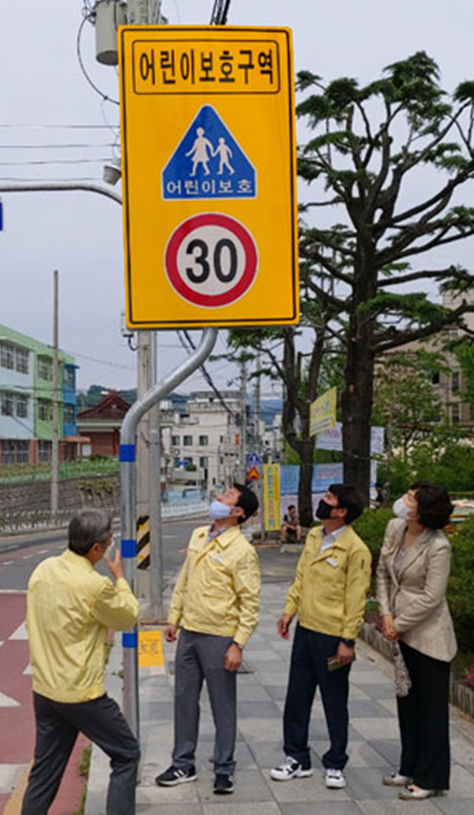

In [4]:
# 필수 패키지 설치
!pip install opencv-python tensorflow scikit-learn matplotlib pillow

# 라이브러리 임포트
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import os
from PIL import Image
import io
from google.colab import files

# === 클래스 정의 ===
class AutonomousDrivingMLSystem:
    def __init__(self):
        self.lane_detector = None
        self.traffic_sign_classifier = None

    def preprocess_image(self, image_path):
        """이미지 전처리"""
        image = cv2.imread(image_path)
        if image is None:
            return None
        image = cv2.resize(image, (224, 224))
        image = image.astype(np.float32) / 255.0
        return image

    def detect_lane_features(self, image):
        """차선 특징 추출"""
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        blur = cv2.GaussianBlur(gray, (5, 5), 0)
        edges = cv2.Canny(blur, 50, 150)
        height = edges.shape[0]
        mask = np.zeros_like(edges)
        polygon = np.array([[
            (0, height),
            (edges.shape[1], height),
            (edges.shape[1], height//2),
            (0, height//2)
        ]], np.int32)
        cv2.fillPoly(mask, polygon, 255)
        masked_edges = cv2.bitwise_and(edges, mask)
        lines = cv2.HoughLinesP(masked_edges, 1, np.pi/180, 50, 100, 50)

        features = []
        if lines is not None:
            for line in lines:
                x1, y1, x2, y2 = line[0]
                if x2 - x1 != 0:
                    slope = (y2 - y1) / (x2 - x1)
                    length = np.sqrt((x2-x1)**2 + (y2-y1)**2)
                    features.extend([slope, length, x1, y1, x2, y2])
        while len(features) < 30:
            features.append(0)
        return features[:30]

    def build_traffic_sign_cnn(self):
        """CNN 모델 생성"""
        model = models.Sequential([
            layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.Flatten(),
            layers.Dense(64, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(4, activation='softmax')
        ])
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        return model

    def generate_sample_data(self):
        np.random.seed(42)
        lane_features, lane_decisions = [], []
        for _ in range(1000):
            features = np.random.randn(30)
            if features[0] < -0.5:
                decision = 0
            elif features[0] > 0.5:
                decision = 2
            else:
                decision = 1
            lane_features.append(features)
            lane_decisions.append(decision)
        sign_images = np.random.rand(500, 64, 64, 3)
        sign_labels = np.random.randint(0, 4, 500)
        return np.array(lane_features), np.array(lane_decisions), sign_images, sign_labels

    def train_lane_keeping_system(self):
        print("차선 유지 시스템 훈련 시작...")
        lane_features, lane_decisions, _, _ = self.generate_sample_data()
        X_train, X_test, y_train, y_test = train_test_split(lane_features, lane_decisions, test_size=0.2)
        self.lane_detector = RandomForestClassifier(n_estimators=100)
        self.lane_detector.fit(X_train, y_train)
        y_pred = self.lane_detector.predict(X_test)
        print(f"차선 유지 시스템 정확도: {accuracy_score(y_test, y_pred):.3f}")
        print(classification_report(y_test, y_pred, target_names=['좌회전', '직진', '우회전']))

    def train_traffic_sign_classifier(self):
        print("\n교통 표지판 분류기 훈련 시작...")
        _, _, sign_images, sign_labels = self.generate_sample_data()
        X_train, X_test, y_train, y_test = train_test_split(sign_images, sign_labels, test_size=0.2)
        self.traffic_sign_classifier = self.build_traffic_sign_cnn()
        self.traffic_sign_classifier.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=1)
        _, acc = self.traffic_sign_classifier.evaluate(X_test, y_test, verbose=0)
        print(f"교통 표지판 분류 정확도: {acc:.3f}")

    def predict_driving_action(self, image_path):
        if not os.path.exists(image_path):
            print("이미지 파일을 찾을 수 없습니다.")
            return
        image = self.preprocess_image(image_path)
        if image is None:
            print("이미지 전처리 실패")
            return
        lane_features = self.detect_lane_features((image * 255).astype(np.uint8))
        if self.lane_detector:
            decision = self.lane_detector.predict([lane_features])[0]
            print(f"차선 분석 결과: {['좌회전', '직진', '우회전'][decision]}")
        if self.traffic_sign_classifier:
            sign_image = cv2.resize((image * 255).astype(np.uint8), (64, 64))
            sign_image = np.expand_dims(sign_image.astype(np.float32) / 255.0, axis=0)
            pred = self.traffic_sign_classifier.predict(sign_image, verbose=0)
            sign_class = np.argmax(pred[0])
            confidence = np.max(pred[0])
            print(f"교통표지판 인식: {['정지', '직진', '좌회전', '우회전'][sign_class]} (신뢰도: {confidence:.3f})")

# === 실행부 ===
def main():
    print("=== 자율주행 지도학습 시스템 ===")
    autonomous_system = AutonomousDrivingMLSystem()
    autonomous_system.train_lane_keeping_system()
    autonomous_system.train_traffic_sign_classifier()

    # 파일 업로드
    print("\n--- 이미지 파일 업로드 ---")
    uploaded = files.upload()

    # 이미지 저장 및 임시 경로 설정
    file_name = list(uploaded.keys())[0]
    image = Image.open(io.BytesIO(uploaded[file_name]))
    image_path = f"/content/{file_name}"
    image.save(image_path)

    # 예측 실행
    print("\n--- 이미지 기반 주행 행동 예측 ---")
    autonomous_system.predict_driving_action(image_path)

main()


=== 자율주행 지도학습 시스템 ===
차선 유지 시스템 훈련 시작...
차선 유지 시스템 정확도: 0.990
              precision    recall  f1-score   support

         좌회전       1.00      1.00      1.00        61
          직진       0.97      1.00      0.99        70
         우회전       1.00      0.97      0.99        69

    accuracy                           0.99       200
   macro avg       0.99      0.99      0.99       200
weighted avg       0.99      0.99      0.99       200


교통 표지판 분류기 훈련 시작...
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 299ms/step - accuracy: 0.2385 - loss: 1.5144 - val_accuracy: 0.2500 - val_loss: 1.3892
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2586 - loss: 1.3877 - val_accuracy: 0.2100 - val_loss: 1.3882
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2414 - loss: 1.3837 - val_accuracy: 0.2700 - val_loss: 1.4282
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2522 - loss: 1.3901 - val_accuracy: 0.2100 - val_loss: 1.3892
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2521 - loss: 1.3860 - val_accuracy: 0.2000 - val_loss: 1.3923
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2914 - loss: 1.3868 - val_accuracy: 0.2400 - val_loss: 1.3903
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3140 - loss: 1.3802 - val_accuracy: 0.2400 - val_loss: 1.3965
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2860 - loss: 1.3772 - val_accuracy: 0.2100 - val_loss: 1

Saving 스크린샷 2025-07-07 112538.png to 스크린샷 2025-07-07 112538 (2).png

--- 이미지 기반 주행 행동 예측 ---
차선 분석 결과: 직진
교통표지판 인식: 우회전 (신뢰도: 0.262)


#OpenCV 기반 교통표지판 인식 시스템 (훈련 불필요, 이미지 분석 자동 실행)

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 0s (52.7 MB/s)
Selecting previously unselected package fonts-nanum.
(Reading database ... 126308 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/

Saving 스크린샷 2025-07-07 112538.png to 스크린샷 2025-07-07 112538 (3).png

📌 예측 결과: unknown_sign
📐 모양: rectangle_guide_sign
📝 텍스트: ['text_included_stop_possible']
🔍 Debug: 'unknown_sign' → 'Unknown Sign'


/tmp/ipython-input-5-378576572.py:228: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


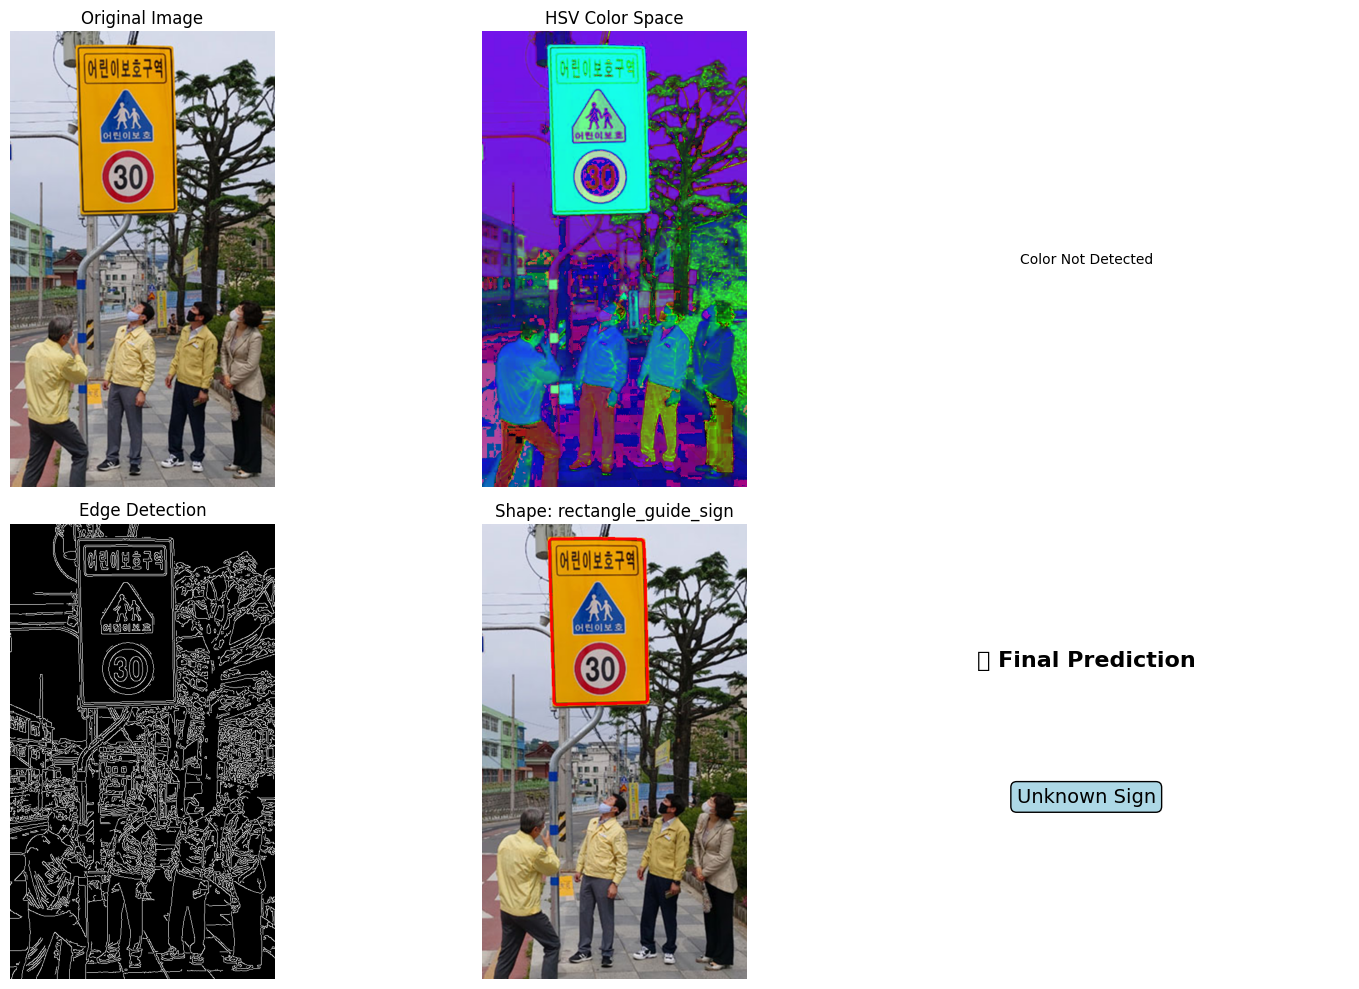

In [5]:
# 패키지 설치
!pip install opencv-python matplotlib pillow

# 시스템 라이브러리 임포트
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import io
from PIL import Image

# 한글 폰트 설정 (Colab 한정)
import matplotlib.font_manager as fm
!apt-get install -y fonts-nanum
!fc-cache -fv
!rm ~/.cache/matplotlib -rf
plt.rcParams['font.family'] = 'NanumBarunGothic'
plt.rcParams['axes.unicode_minus'] = False

# =============================================
# ▶ OpenCV 교통표지판 인식 시스템 클래스
# =============================================
class OpenCVTrafficSignRecognizer:
    def __init__(self):
        self.color_ranges = {
            'red': {
                'lower1': np.array([0, 120, 70]),
                'upper1': np.array([10, 255, 255]),
                'lower2': np.array([170, 120, 70]),
                'upper2': np.array([180, 255, 255]),
                'sign_type': 'stop_prohibition'
            },
            'blue': {
                'lower': np.array([90, 100, 50]),
                'upper': np.array([150, 255, 255]),
                'sign_type': 'direction_guide'
            },
            'yellow': {
                'lower': np.array([15, 150, 150]),
                'upper': np.array([35, 255, 255]),
                'sign_type': 'warning_caution'
            },
            'green': {
                'lower': np.array([40, 150, 100]),
                'upper': np.array([80, 255, 255]),
                'sign_type': 'safety_permission'
            }
        }

    def detect_color(self, image):
        hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        detected_colors = []

        for color_name, color_info in self.color_ranges.items():
            if color_name == 'red':
                mask1 = cv2.inRange(hsv, color_info['lower1'], color_info['upper1'])
                mask2 = cv2.inRange(hsv, color_info['lower2'], color_info['upper2'])
                mask = cv2.bitwise_or(mask1, mask2)
            else:
                mask = cv2.inRange(hsv, color_info['lower'], color_info['upper'])

            color_pixels = cv2.countNonZero(mask)
            total_pixels = image.shape[0] * image.shape[1]
            color_ratio = color_pixels / total_pixels

            if color_ratio > 0.1:
                detected_colors.append({
                    'color': color_name,
                    'ratio': color_ratio,
                    'sign_type': color_info['sign_type'],
                    'mask': mask
                })

        return max(detected_colors, key=lambda x: x['ratio']) if detected_colors else None

    def detect_shapes(self, image):
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)
        edges = cv2.Canny(blurred, 50, 150)
        contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        shapes = []
        for contour in contours:
            if cv2.contourArea(contour) < 500:
                continue
            epsilon = 0.02 * cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, epsilon, True)
            vertices = len(approx)

            if vertices == 3:
                shape_type = "triangle_warning_sign"
            elif vertices == 4:
                x, y, w, h = cv2.boundingRect(approx)
                ar = w / float(h)
                shape_type = "square_general_sign" if 0.95 <= ar <= 1.05 else "rectangle_guide_sign"
            elif 5 <= vertices <= 10:
                shape_type = "octagon_stop_sign"
            else:
                area = cv2.contourArea(contour)
                peri = cv2.arcLength(contour, True)
                circ = 4 * np.pi * area / (peri * peri) if peri > 0 else 0
                shape_type = "circle_direction_sign" if circ > 0.7 else "other_shape"

            shapes.append({
                'shape': shape_type,
                'vertices': vertices,
                'area': cv2.contourArea(contour),
                'contour': contour
            })

        return max(shapes, key=lambda x: x['area']) if shapes else None

    def detect_text_patterns(self, image):
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        _, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)
        h, w = binary.shape
        region = binary[h//3:2*h//3, w//4:3*w//4]
        white_ratio = cv2.countNonZero(region) / (region.size)
        return ["text_included_stop_possible"] if white_ratio > 0.3 else []

    def classify_traffic_sign(self, image):
        color_info = self.detect_color(image)
        shape_info = self.detect_shapes(image)
        text_info = self.detect_text_patterns(image)

        classification = {
            'color_info': color_info,
            'shape_info': shape_info,
            'text_info': text_info,
            'final_prediction': 'unknown_sign'
        }

        if color_info and shape_info:
            c, s = color_info['color'], shape_info['shape']
            if c == 'red':
                if 'octagon' in s or 'text_included' in str(text_info):
                    classification['final_prediction'] = 'stop_sign'
                else:
                    classification['final_prediction'] = 'prohibition_sign'
            elif c == 'blue':
                classification['final_prediction'] = 'direction_sign' if 'circle' in s else 'guide_sign'
            elif c == 'yellow':
                classification['final_prediction'] = 'warning_sign' if 'triangle' in s else 'caution_sign'
            elif c == 'green':
                classification['final_prediction'] = 'safety_sign'
        elif color_info:
            classification['final_prediction'] = color_info['sign_type']
        elif shape_info:
            s = shape_info['shape']
            if 'octagon' in s:
                classification['final_prediction'] = 'stop_sign_by_shape'
            elif 'triangle' in s:
                classification['final_prediction'] = 'warning_sign_by_shape'
            elif 'circle' in s:
                classification['final_prediction'] = 'direction_sign_by_shape'

        return classification

    def convert_prediction_to_english(self, prediction):
        conversion = {
            'stop_sign': 'STOP Sign',
            'direction_sign': 'Direction Sign',
            'warning_sign': 'Warning Sign',
            'caution_sign': 'Caution Sign',
            'safety_sign': 'Safety Sign',
            'prohibition_sign': 'Prohibition Sign',
            'guide_sign': 'Guide Sign',
            'stop_sign_by_shape': 'STOP Sign (by shape)',
            'warning_sign_by_shape': 'Warning Sign (by shape)',
            'direction_sign_by_shape': 'Direction Sign (by shape)',
            'unknown_sign': 'Unknown Sign',
            'stop_prohibition': 'STOP/Prohibition Sign',
            'direction_guide': 'Direction/Guide Sign',
            'warning_caution': 'Warning/Caution Sign',
            'safety_permission': 'Safety/Permission Sign'
        }
        result = conversion.get(prediction, f'Unclassified: {prediction}')
        print(f"🔍 Debug: '{prediction}' → '{result}'")
        return result

    def visualize_detection(self, image, classification):
        plt.figure(figsize=(15, 10))

        plt.subplot(2, 3, 1)
        plt.imshow(image)
        plt.title('Original Image')
        plt.axis('off')

        hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        plt.subplot(2, 3, 2)
        plt.imshow(hsv)
        plt.title('HSV Color Space')
        plt.axis('off')

        plt.subplot(2, 3, 3)
        if classification['color_info']:
            plt.imshow(classification['color_info']['mask'], cmap='gray')
            plt.title(f"Color: {classification['color_info']['color']}")
        else:
            plt.text(0.5, 0.5, 'Color Not Detected', ha='center', va='center', transform=plt.gca().transAxes)
        plt.axis('off')

        edges = cv2.Canny(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY), 50, 150)
        plt.subplot(2, 3, 4)
        plt.imshow(edges, cmap='gray')
        plt.title('Edge Detection')
        plt.axis('off')

        plt.subplot(2, 3, 5)
        shape_image = image.copy()
        if classification['shape_info']:
            cv2.drawContours(shape_image, [classification['shape_info']['contour']], -1, (255, 0, 0), 3)
            plt.imshow(shape_image)
            plt.title(f"Shape: {classification['shape_info']['shape']}")
        else:
            plt.imshow(image)
            plt.title('Shape Not Detected')
        plt.axis('off')

        plt.subplot(2, 3, 6)
        plt.text(0.5, 0.7, '🎯 Final Prediction', ha='center', va='center',
                 transform=plt.gca().transAxes, fontsize=16, fontweight='bold')
        prediction_text = self.convert_prediction_to_english(classification['final_prediction'])
        plt.text(0.5, 0.4, prediction_text, ha='center', va='center',
                 transform=plt.gca().transAxes, fontsize=14,
                 bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))
        plt.axis('off')
        plt.tight_layout()
        plt.show()

# =============================================
# ▶ 실행 함수: 업로드 후 자동 분석
# =============================================
def main():
    print("🚗 OpenCV 교통표지판 인식 시스템 시작!")
    recognizer = OpenCVTrafficSignRecognizer()

    # 이미지 업로드
    print("📁 교통표지판 이미지를 업로드해주세요:")
    uploaded = files.upload()

    for filename, data in uploaded.items():
        image = Image.open(io.BytesIO(data)).convert("RGB")
        image_np = np.array(image)

        result = recognizer.classify_traffic_sign(image_np)

        print(f"\n📌 예측 결과: {result['final_prediction']}")
        if result['color_info']:
            print(f"🎨 색상: {result['color_info']['color']} ({result['color_info']['ratio']:.1%})")
        if result['shape_info']:
            print(f"📐 모양: {result['shape_info']['shape']}")
        if result['text_info']:
            print(f"📝 텍스트: {result['text_info']}")

        # 시각화
        recognizer.visualize_detection(image_np, result)

main()


# 🧪 OpenCV 입문 실습 1: 컬러 이미지 생성 및 시각화

🎉 OpenCV 버전: 4.11.0

🎨 테스트 1: 이미지 생성하기


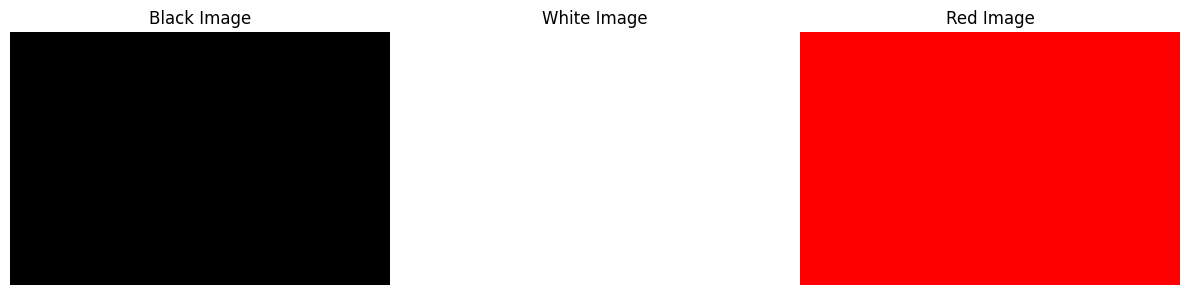

In [6]:
# OpenCV 초보자 테스트 코드 - Colab에서 실행하세요!

import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import io
from PIL import Image

print(f"🎉 OpenCV 버전: {cv2.__version__}")

# =============================================================================
# 📝 테스트 1: 간단한 이미지 생성하기
# =============================================================================

def test1_create_image():
    """간단한 이미지 만들어보기"""
    print("\n🎨 테스트 1: 이미지 생성하기")

    # 1. 빈 캔버스 만들기 (검은색)
    black_img = np.zeros((200, 300, 3), dtype=np.uint8)

    # 2. 흰색 캔버스 만들기
    white_img = np.ones((200, 300, 3), dtype=np.uint8) * 255

    # 3. 빨간색 캔버스 만들기
    red_img = np.zeros((200, 300, 3), dtype=np.uint8)
    red_img[:, :, 2] = 255  # BGR에서 R채널

    # 결과 출력
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(black_img)
    plt.title('Black Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(white_img)
    plt.title('White Image')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(red_img, cv2.COLOR_BGR2RGB))
    plt.title('Red Image')
    plt.axis('off')

    plt.tight_layout()
    plt.show()
# 함수 실행 코드 추가
if __name__ == "__main__":
    test1_create_image()


# 🖌️ OpenCV 입문 실습 2: 도형 및 텍스트 그리기


🔺 테스트 2: 도형 그리기


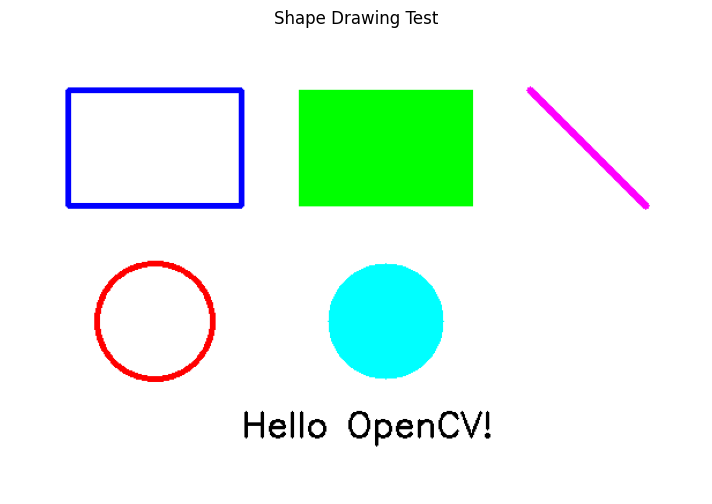

In [7]:
# =============================================================================
# 📝 테스트 2: 도형 그리기
# =============================================================================

def test2_draw_shapes():
    """도형 그리기 연습"""
    print("\n🔺 테스트 2: 도형 그리기")

    # 캔버스 생성
    canvas = np.ones((400, 600, 3), dtype=np.uint8) * 255

    # 1. 사각형 그리기
    cv2.rectangle(canvas, (50, 50), (200, 150), (255, 0, 0), 3)  # 파란색 테두리
    cv2.rectangle(canvas, (250, 50), (400, 150), (0, 255, 0), -1)  # 초록색 채우기

    # 2. 원 그리기
    cv2.circle(canvas, (125, 250), 50, (0, 0, 255), 3)  # 빨간색 테두리
    cv2.circle(canvas, (325, 250), 50, (255, 255, 0), -1)  # 노란색 채우기

    # 3. 직선 그리기
    cv2.line(canvas, (450, 50), (550, 150), (255, 0, 255), 5)  # 보라색 선

    # 4. 텍스트 쓰기
    cv2.putText(canvas, 'Hello OpenCV!', (200, 350),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2)

    # 결과 출력
    plt.figure(figsize=(10, 6))
    plt.imshow(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
    plt.title('Shape Drawing Test')
    plt.axis('off')
    plt.show()

# 함수 실행 코드 추가
if __name__ == "__main__":
    test2_draw_shapes()